In [190]:
import sys
import math
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import t, chi2, f, norm, poisson, binom, uniform, expon, geom

np.set_printoptions(suppress = True)                      # уберем scientific notation

### Часть №1. Генерация выборки из равномерного распределения

Два подхода к формированию случайных чисел.
 1. Случайный. За основу берется результат некоторого непредсказуемого физического процесса. На данный момент этот подход весьма ресурсозатратен и поэтому применяется относительно редко.
 2. Псевдослучайный. За основу берется одно число, полученное случайным образом, например, исходя из времени на внутренних часах компьютера, а затем из него, в соответствии с заранее заданным алгоритмом, генерируются другие случайные числа из того же распределения.
Большинство приложений и библиотек предполагают применение пвсевдослучайного подхода. В дальнейшем будем пользоваться лишь им.

In [5]:
np.random.rand() # сгенерируем случайное число из стандартного

0.1919103947268188

In [13]:
np.random.seed(123) # установим заранее зерно, из которого будет осуществляться

In [14]:
np.random.rand()

0.6964691855978616

Для воспроизводимости результатов, полученных с использованием выборок, необходима установка случайного зерна

In [15]:
n = 1000
u = np.random.uniform(size = n, # объем выборки
                      low = 0,  # наименьшее значение
                      high = 1) # наибольшее значение
u                               # реализация выборки из U~(0,1) объемом n

array([0.28613933, 0.22685145, 0.55131477, 0.71946897, 0.42310646,
       0.9807642 , 0.68482974, 0.4809319 , 0.39211752, 0.34317802,
       0.72904971, 0.43857224, 0.0596779 , 0.39804426, 0.73799541,
       0.18249173, 0.17545176, 0.53155137, 0.53182759, 0.63440096,
       0.84943179, 0.72445532, 0.61102351, 0.72244338, 0.32295891,
       0.36178866, 0.22826323, 0.29371405, 0.63097612, 0.09210494,
       0.43370117, 0.43086276, 0.4936851 , 0.42583029, 0.31226122,
       0.42635131, 0.89338916, 0.94416002, 0.50183668, 0.62395295,
       0.1156184 , 0.31728548, 0.41482621, 0.86630916, 0.25045537,
       0.48303426, 0.98555979, 0.51948512, 0.61289453, 0.12062867,
       0.8263408 , 0.60306013, 0.54506801, 0.34276383, 0.30412079,
       0.41702221, 0.68130077, 0.87545684, 0.51042234, 0.66931378,
       0.58593655, 0.6249035 , 0.67468905, 0.84234244, 0.08319499,
       0.76368284, 0.24366637, 0.19422296, 0.57245696, 0.09571252,
       0.88532683, 0.62724897, 0.72341636, 0.01612921, 0.59443

 Посмотрим, как работает ЗБЧ

In [18]:
print(np.mean(u))        # примерно равно E(U) = 0.5
print(np.mean(u <= 0.35))  # примерно равно P(U <= 0.35) = 0.35
print(np.mean(u ** 2))   # примерно равно E(U ^ 2)

0.4987584562937045
0.346
0.33008242030619694


Чем больше объем выборки, тем, в силу ЗБЧ, с меньшей вероятностью данные значения будут сильно отличаться от истинных

Посмотрим, как с объемом выборки меняется точность аппроксимации E(U):

In [19]:
np.random.seed(333333)
n_new = 100000                              # объем новой выборки из U~(0,1)
u_new = np.random.uniform(size = n_new)     # создадим новую большую выборку
step = 10                                   # разобьем эту большую выборку на
                                            # подвыборки, первая из которых
                                            # имеет объем step, а каждая следующая
                                            # на step больше предыдущей
m = int(len(u_new) / step)                  # количество таких выборок
u_mean = np.zeros(m)                        # здесь будем сохраняться аппроксимацию E(U), полученную
                                            # на каждой из подвыборок

In [24]:
for i in range(0, m):
    u_mean[i] = np.mean(u_new[0:((i + 1) * step - 1)])  # аппроксимируем E(U) на очередной подвыборке
dev = abs(u_mean - 0.5) # считаем абсолютные отклонения аппроксимации
                        # от истинного значения: вспомним, что E(U) = 0.5
dev

array([0.0299085 , 0.03244446, 0.05984874, ..., 0.000186  , 0.00018075,
       0.0001714 ])

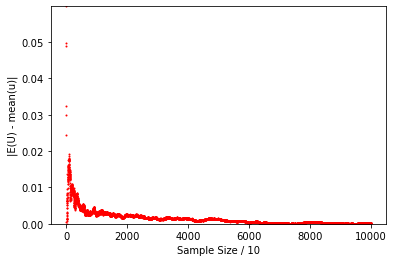

In [25]:
# Визуализируем результат
plt.xlabel('Sample Size / ' + str(step))
plt.ylabel('|E(U) - mean(u)|')
plt.ylim(ymin = 0, ymax = max(dev))
plt.plot(dev, 'ro', markersize = 1)
# Вывод: по мере увеличения объемов
# подвыборки вероятность отклоения аппроксимации
# от истины уменьшается и стремится к нулю.
# Примечание: вместо подвыборок можно было бы
# использовать новые выборки, но это существенно
# увеличило бы вычислительную нагрузку.

### Часть №2. Генерация выборки из дискретного распределения с конечным носителем

In [27]:
# Пусть случайная величина Y имеет следующую таблицу распределения:
# t         |   -3   |   0   |   3    |   5    |  8
# P(Y = t)  |   0.1  |   0.2 |   0.3  |  0.35  | 0.05

# Создадим переменные, отражающие некоторые
# характеристики данного распределения.
# Пусть здесь и далее t принадлежит supp(Y):
t_y = np.array([-3, 0, 3, 5, 8])                         # supp(Y)          - носитель
p_y = np.array([0.1, 0.2, 0.3, 0.35, 0.05])              # P(Y = t),        - функция вероятности
F_y = np.cumsum(p_y)                                     # P(Y <= t) = F(Y) - функция распределения
pd.DataFrame(                                      # визуализируем результат
    {'t': t_y,
     'P(Y = t)': p_y,
     'P(Y <= t)': F_y})

,t,P(Y = t),P(Y <= t)
0,-3,0.10,0.10
1,0,0.20,0.30
2,3,0.30,0.60
3,5,0.35,0.95
4,8,0.05,1.00


In [32]:
# Вспомним, как выбирать элементы вектора
# по логическому вектору
is_select = t_y > 0 # получаем логический (bool) вектор
p_y[is_select] # выбираем те значения из вектора вероятностей,
               # которые соответствуют условию, то есть берем
               # лишь те элементы вектора 'p_y', для которых соответствующие
               # элементы вектора 'is_select' равняются 'True'

array([0.3 , 0.35, 0.05])

In [33]:
print(p_y[[True, False, True, False, True]]) # еще нескольких скохих примеров
print(p_y[(t_y > 0) & (t_y < 6)])

[0.1  0.3  0.05]
[0.3  0.35]


In [35]:
# Сгенерируем выборку из распредедения такого
# же, как у случайной величины Y.
y = np.zeros(n) # создадим вектор, в котором будем сохранять
y                # реализации выборки

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Найдем реализации из распределения случайной величины Y используя реализации из стандартного равномерного распределения U~(0,1). При формировании выборки из Y необходимо, чтобы каждое из возможных значений t появлялось в ней с соответствующей вероятностью P(Y = t).
Обратим внимание, что:
P(Y = -3) = 0.1 = P(U <= 0.1).
Следовательно, присваивать в выборке из Y значения -3
нужно с такой же вероятностью, как в выборке из U
возникают значения меньше 0.1. А значит достаточно в
выборке из Y везде поставить -3, где в выборке из U
фигурирует число меньше 0.1.

In [36]:
y[u <= F_y[0]] = t_y[0]
# Вновь обратим внимание, что:
# P(Y = 0) = P(Y <= 0) - P(Y <= -3) = 0.3 - 0.1 = P(0.1 <= U <= 0.3)
# Седовательно, присваивать в выборке из Y значения 0
# нужно с такой же вероятностью, как в выборке из U
# возникают значения между 0.3 и 0.1. А значит достаточно в
# выборке из Y везде поставить 0, где в выборке из U
# фигурирует число от 0.1 до 0.3.
y[(u >= F_y[0]) & (u <= F_y[1])] = t_y[1]
# Поступаем по аналогии для остальных значений
for i in range(2, len(t_y)):
    y[(u >= F_y[i - 1]) & (u <= F_y[i])] = t_y[i]

y

array([ 0.,  0.,  3.,  5.,  3.,  8.,  5.,  3.,  3.,  3.,  5.,  3., -3.,
        3.,  5.,  0.,  0.,  3.,  3.,  5.,  5.,  5.,  5.,  5.,  3.,  3.,
        0.,  0.,  5., -3.,  3.,  3.,  3.,  3.,  3.,  3.,  5.,  5.,  3.,
        5.,  0.,  3.,  3.,  5.,  0.,  3.,  8.,  3.,  5.,  0.,  5.,  5.,
        3.,  3.,  3.,  3.,  5.,  5.,  3.,  5.,  3.,  5.,  5.,  5., -3.,
        5.,  0.,  0.,  3., -3.,  5.,  5.,  5., -3.,  3.,  3.,  0.,  0.,
        5.,  3.,  5.,  3.,  3.,  5.,  5.,  3., -3.,  3.,  3.,  5.,  8.,
        3.,  5.,  3.,  5.,  0.,  3.,  0.,  3.,  3.,  5.,  0.,  0.,  3.,
        5.,  5.,  3.,  5.,  3.,  3.,  3.,  0.,  5.,  3.,  3.,  3.,  3.,
       -3.,  8.,  5.,  0.,  0.,  3.,  5.,  8.,  0.,  3.,  5.,  3.,  5.,
        0.,  5.,  5.,  8., -3.,  3.,  0.,  3.,  3., -3.,  0.,  5.,  3.,
        3.,  5.,  5., -3.,  5.,  5.,  0.,  5.,  0.,  3.,  5.,  0.,  5.,
        5.,  5.,  3.,  3.,  5.,  3., -3.,  3.,  5.,  3.,  5.,  5.,  3.,
        5., -3.,  5.,  5.,  5.,  0., -3.,  0.,  3.,  3.,  3.,  0

### Часть №3. Генерация выборки из непрерывного распределения с квантильной функцией

In [37]:
# Квантильная функция это функция, обратная функции распределения.
# Если для некоторого распределения она существует, то получить
# выборку из этого распределения можно при помощи метода обратного
# преобразования (inverse transform sampling).

# Рассмотрим случайную величину X со
# следующей функцией плотности:
def f_X(x):                            # создаем функцию "f_X" принимающую в качестве аргумента "x"
    if (x >= 7) & (x <= 10):           # если аргумент принадлежит носителю X, то есть интервалу [7, 10],
        value = (1 / 219) * (x ** 2)   # то осуществляем расчет,
        return value                   # и возвращаем полученный результат,
    return 0                           # а в противном случае возвращаем 0




In [38]:
# Рассчитаем значение данной функции
# плотности в нескольких точках:
f_X(8)                                 # осуществим рассчет в точке, принадлежащей носителю X
f_X(5)                                 # получим 0, поскольку x < 7  (при x = 5)
f_X(12)                                # получим 0, поскольку x > 10 (при x = 12)


0

In [39]:
# Теперь запрограммируем функцию распределения
# случайной величины X:
def F_X(x):
    if (x < 7):                         # возвращаем 0, если x < 7
        return 0
    if (x >= 7) & (x <= 10):            # если аргумент функции распределения принадлежит
                                        # носителю x, то осуществляем данный расчет
        return (1 / 657) * \
               (x ** 3 - 343)
    return 1                            # возвращаем 1, если x > 10



In [40]:
# При помощи запрограмированной функции
# распределения осуществим следующие
# расчеты:
F_X(5)                                  # полуем 0, поскольку x < 7
F_X(12)                                 # полуем 1, поскольку x > 10
F_X(9)                                  # P(X < 9)



0.5875190258751902

In [42]:
# Наконец, запрограммируем квантильную
# функцию, то есть если на вход подать
# значение x, то на выходе функция выдаст
# такое число y, что P(X <= y) = x:
def q_X(x):
        return (657 * x + 343) ** (1 / 3)

# Проверим, что квантильная функция
# работает корректно:
print(q_X(0.3))     # находим квантиль уровня 0.3
print(F_X(q_X(0.3))) # получили вновь 0.3, значит все работает верно

8.143755488687901
0.2999999999999995


In [44]:
# Сгенерируем выборку из X используя метод
# обратного преобразования
x = q_X(u)
x

array([8.09772604, 7.89466822, 8.90103007, 9.34347821, 8.53151367,
       9.95769487, 9.25576223, 8.70206609, 8.43723647, 8.2839092 ,
       9.36745064, 8.57779545, 7.2571606 , 8.45543026, 9.38972387,
       7.73561434, 7.70976332, 8.84606208, 8.84683503, 9.12501042,
       9.65874243, 9.35597014, 9.06310565, 9.35093379, 8.21887387,
       8.34288132, 7.8996258 , 8.1229453 , 9.11599374, 7.38956983,
       8.56327257, 8.55478722, 8.7387932 , 8.53970125, 8.18404404,
       8.54126559, 9.76084852, 9.87618372, 8.76210763, 9.09744762,
       7.48269364, 8.20043901, 8.50652703, 9.69820038, 7.97675112,
       8.7081419 , 9.96827539, 8.81216346, 9.06809137, 7.50223953,
       9.60422957, 9.04182388, 8.8837294 , 8.28258719, 8.15734021,
       8.51316802, 9.24673214, 9.71945345, 8.78653017, 9.21592687,
       8.99571943, 9.09996217, 9.22976617, 9.64207151, 7.35366166,
       9.45310081, 7.95331564, 7.7783119 , 8.95909096, 7.40401002,
       9.74228089, 9.10616084, 9.35337005, 7.07135779, 9.01865

In [45]:
# Сравним истинные значения функции
# распределения и рассчитываемые
# при помощи ЗБЧ
F_X(8)                                     # P(X <= 8)
np.mean(x <= 8)                            # приблизительное значение P(X <= 8)



0.246

### Часть №4. Генерация выборок из известных распределений

In [48]:
# Выборка из Хи-Квадрат распределения
# с 5-ю степенями свободы
chi2.rvs(size = 1000,                      # объем выборки
         df = 5)                           # число степеней свободы

# Выборка из распределения Стьюдента
# с 5-ю степенями свободы
t.rvs(size = 1000,                         # объем выборки
      df = 5)                              # число степеней свободы

# Выборка из распределения Фишера
# с 5-ю и 10-ю степенями свободы
f.rvs(size = 1000,                         # объем выборки
      dfn = 5,                             # первое число степеней свободы
      dfd = 10)                            # второе число степеней свободы

# Выборка из нормального распределения
# с математическим ожиданием 5 и
# дисперсией 10
norm.rvs(size = 1000,                      # объем выборки
         loc = 5,                          # первое число степеней свободы
         scale = 10)                       # второе число степеней свободы

# Выборка из распределения Пуассона
# с параметром lambda = 5
poisson.rvs(size = 1000,                   # объем выборки
            mu = 5)                        # лямбда

# Выборка из Биномиального распределения
# с параметром 0.6 и 10
binom.rvs(size = 1000,                     # объем выборки
          n = 10,                          # число независимых испытаний Бернулли
          p = 0.6)                         # вероятность успеха в одном испытании

2 == 2

True

## Задания

In [ ]:
# 1. Симулируйте выборку объемом в 10000
#    наблюдений из распределения:
#    1) Хи-Квадрат с 5-ю степенями свободы
#    2) Стьюдента с 10-ю степенями свободы
#    3) Нормального с математическим ожиданием 10
#           и дисперсией 25

In [173]:
# 1)
v1 = chi2.rvs(size = 10000, df = 5)
v2 = t.rvs(size = 10000, df = 10)
v3 = norm.rvs(size = 10000,                      
         loc = 10,                         
         scale = 5)


In [54]:
# 2. Симулируйте выборку из Хи-Квадрат распределения
#    с 10-ю степенями свободы. При помощи ЗБЧ найдите
#    аппроксимации:
#    1)    E(X)
#    2)    E(X ^ 3)
#    2)    Var(X)
#    3*)   Median(X)
#    4)    P(X <= 1.7)
#    5*)   квантиль X уровня 0.3
#    6)    Var(sin(X))

In [175]:
chi = chi2.rvs(size = 10000000,                      
         df = 10) 
print('E(X) =', np.mean(chi))
print('E(X ^ 3) =', np.mean(chi ** 3))
print('Var(X) =', np.var(chi))
print('Median(X) =', (sorted(chi))[4999999])
print('P(X <= 1.7) =', np.mean(chi <= 1.7))
print('квантиль X уровня 0.3 =', (np.quantile(chi, 0.3)))
print('Var(sin(X)) =', np.var(np.sin(chi)))

E(X) = 9.999423113100777
E(X ^ 3) = 1679.7414249270148
Var(X) = 19.998239138298853
Median(X) = 9.341414352348188
P(X <= 1.7) = 0.0018191
квантиль X уровня 0.3 = 7.265847872470225
Var(sin(X)) = 0.4992573387997966


In [ ]:
# 3. Пусть X и Y независимые случайные величины, причем
#    X~U(1,5) и Y~chi2(5). При помощи ЗБЧ аппроксимируйте:
#    1)    E(X + Y)
#    2)    P(X - Y <= 2)
#    3)    Var(X / Y)

In [120]:
x1 = np.random.uniform(size = 100000, low = 1, high = 5)
x2 = chi2.rvs(size = 100000, df = 5)

In [121]:
# 1
print('E(X + Y) =', np.mean(x1 + x2))

E(X + Y) = 7.996185655050194


In [125]:
# 2
print('P(X - Y <= 2) =', np.mean(x1 - x2 <= 2))

P(X - Y <= 2) = 0.91797


In [126]:
# 3
print('Var(X / Y) =', np.var(x1 / x2))

Var(X / Y) = 2.0756840670826184


In [127]:
# 4. В предыдущих задачах постройте графики, демонстрирующие,
#    что вероятность отклонения аппроксимаций от истинных
#    значений снижается по мере увеличения объема выборки.
#    В качестве метрики используйте:
#    1*)   Абсолютное отклонение
#    2*)   Квадрат абсолютного отклонения

In [143]:
# 1
# Хи-квадрат с 10 степенями свободы
np.random.seed(333333)
n_new = 100000                              # объем новой выборки из U~(0,1)
chi_new = chi2.rvs(size = n_new,                      # объем выборки
         df = 10)  # создадим новую большую выборку
step = 10                                   # разобьем эту большую выборку на
                                            # подвыборки, первая из которых
                                            # имеет объем step, а каждая следующая
                                            # на step больше предыдущей
m = int(len(chi_new) / step)                # количество таких выборок
chi_mean = np.zeros(m)                      # здесь будем сохраняться аппроксимацию E(U), полученную
                                            # на каждой из подвыборок
for i in range(0, m):
    chi_mean[i] = np.mean(chi_new[0:((i + 1) * step - 1)])  # аппроксимируем E(U) на очередной подвыборке
dev = abs(chi_mean - 10) # считаем абсолютные отклонения аппроксимации
                        # от истинного значения: вспомним, что E(chi) = 10
dev_2 = dev **2
dev

array([2.23778803, 1.85342794, 0.76125045, ..., 0.0147572 , 0.01486619,
       0.01478988])

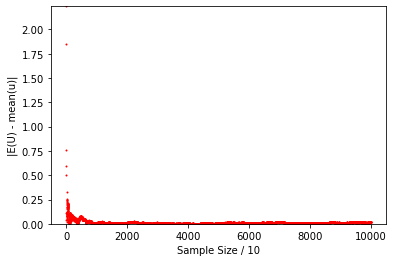

In [144]:
# Визуализируем результат (абсолютное отклонение)
plt.xlabel('Sample Size / ' + str(step))
plt.ylabel('|E(U) - mean(u)|')
plt.ylim(ymin = 0, ymax = max(dev))
plt.plot(dev, 'ro', markersize = 1)
# Вывод: по мере увеличения объемов
# подвыборки вероятность отклоения аппроксимации
# от истины уменьшается и стремится к нулю.
# Примечание: вместо подвыборок можно было бы
# использовать новые выборки, но это существенно
# увеличило бы вычислительную нагрузку.

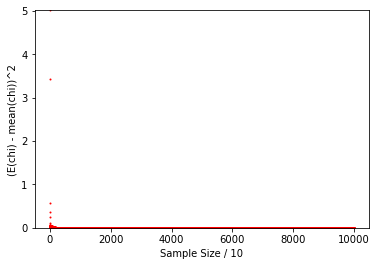

In [145]:
# (квадрат отклонения)
plt.xlabel('Sample Size / ' + str(step))
plt.ylabel('(E(chi) - mean(chi))^2')
plt.ylim(ymin = 0, ymax = max(dev_2))
plt.plot(dev_2, 'ro', markersize = 1)

In [146]:
# 3 часть задачи (сумма двух распределений)
np.mean(x1 + x2)
np.random.seed(333333)
n_new = 100000                              
p3_new = np.random.uniform(size = n_new, low = 1, high = 5) + chi2.rvs(size = n_new, df = 5)
step = 10                                   # разобьем эту большую выборку на
                                            # подвыборки, первая из которых
                                            # имеет объем step, а каждая следующая
                                            # на step больше предыдущей
m = int(len(p3_new) / step)                # количество таких выборок
p3_mean = np.zeros(m)                      # здесь будем сохраняться аппроксимацию E(U), полученную
                                            # на каждой из подвыборок
for i in range(0, m):
    p3_mean[i] = np.mean(p3_new[0:((i + 1) * step - 1)])  # аппроксимируем E(U) на очередной подвыборке
dev = abs(p3_mean - 8) # считаем абсолютные отклонения аппроксимации
                        # от истинного значения: вспомним, что E(X + Y) = 8
dev_2 = dev **2
dev

array([0.30563554, 0.40521755, 0.4383252 , ..., 0.01286705, 0.01301133,
       0.01289232])

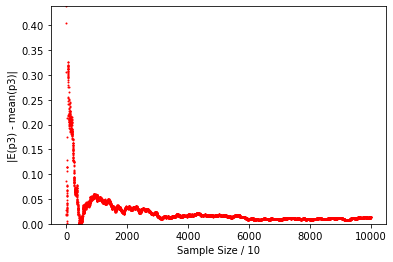

In [147]:
plt.xlabel('Sample Size / ' + str(step))
plt.ylabel('|E(p3) - mean(p3)|')
plt.ylim(ymin = 0, ymax = max(dev))
plt.plot(dev, 'ro', markersize = 1)

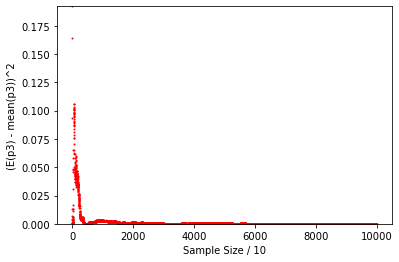

In [148]:
plt.xlabel('Sample Size / ' + str(step))
plt.ylabel('(E(p3) - mean(p3))^2')
plt.ylim(ymin = 0, ymax = max(dev_2))
plt.plot(dev_2, 'ro', markersize = 1)

Остальные пункты можно сделать по аналогии. По уже сделанным пунктам можно увидеть, что, действительно с ростом числа наблюдений отклонения становятся все ближе к нулю.

In [149]:
# 5. Не используя встроенные функции симулируйте выборку из:
#    1)    Распределения Бернулли с параметром p = 0.3
#    2)    Биномиального распределения с
#          параметрами n = 5, p = 0.3 (используйте встроенную квантильную функцию)
#    3)    Экспоненциального распределения с параметром lambda = 5
#    4)    Нормального распределения с
#          параметрами mu = 5, sigma = 25 (используйте встроенную квантильную функцию)
#    5*)   Геометрического распределения с
#          вероятностью успеха 0.3
#    6**)  Распределения Пуассона с математическим
#          ожидаем 5
#    7**)  Суммы распределений из предыдущих двух пунктов,
#          предполагая независимость.

In [169]:
# 1 
bernulli = np.random.sample(10000000)
bernulli = (bernulli <= 0.3) * 1
bernulli.mean()

0.3003083

In [178]:
# 2
bi = binom(5, 0.3) # генерируем функцию распределения
y_out = bi.ppf(u) # выборка с помощью квантильной функции (bi.ppf -- квантильная функция)
y_out.mean() # проверяем, что мат ожидание то самое)

1.502

In [186]:
# 3
y_exp = expon(scale = 1 / 5).ppf(u) # искомая выборка, но можно было выразить х через функцию распределения, но так быстрее
np.mean(y_exp)

0.1994398294350168

In [189]:
# 4
y_norm = norm(5, 5).ppf(u) # выборка
y_norm.var()

24.889255867167318

In [193]:
# 5
y_geom = geom(0.3).ppf(u)
y_geom.mean()

3.336

In [196]:
# 6
y_pois = poisson(5).ppf(u)
y_pois.mean()

4.985

In [199]:
y = poisson(5).ppf(u) + geom(0.3).ppf(u)
y.mean()

8.321